In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

### Reading and Understanding the Data

In [2]:
bike = pd.read_csv("day.csv")
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### Data cleaning 

In [3]:
bike.shape

(730, 16)

In [4]:
bike.info()
# there are no null entries in the datasets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
bike.drop_duplicates(subset=None, inplace=True)
bike.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 97.0+ KB


- No Duplicate enteries in the dataset, As the count is same as before

In [77]:
# lets describe and check for anything out of ordinary in the dataset
bike.describe()

,yr,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,20.319259,62.765175,12.763620,4508.006849
std,0.500343,7.506729,14.237589,5.195841,1936.011647
min,0.000000,2.424346,0.000000,1.500244,22.000000
25%,0.000000,13.811885,52.000000,9.041650,3169.750000
50%,0.500000,20.465826,62.625000,12.125325,4548.500000
75%,1.000000,26.880615,72.989575,15.625589,5966.000000
max,1.000000,35.328347,97.250000,34.000021,8714.000000


In [7]:
# identifying the categorical columns 
print(bike.holiday.value_counts())
print(bike.workingday.value_counts())
print(bike.season.value_counts())
print(bike.weathersit.value_counts())
print(bike.mnth.value_counts())
print(bike.weekday.value_counts())

0    709
1     21
Name: holiday, dtype: int64
1    499
0    231
Name: workingday, dtype: int64
3    188
2    184
1    180
4    178
Name: season, dtype: int64
1    463
2    246
3     21
Name: weathersit, dtype: int64
1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64
6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64


#### From analyzing above  and describe output
- on analyzing columns like holiday , workingday ,season ,weathersit ,mnth & weekday they belong to categorical. 
- holiday,workingday seems to 1/0
- season seems to be 1-4 we need to convert to categorical using data dictionary give.
- weathersit same as season . need conversion 
- mnth and weekday need similar conversion as above. 

In [8]:
## season, weathersit , mnth , weekday, holiday and workingday are categorical variable. lets convert them into category type using the data dict given.
## converting as category can help as draw plot on all these column together.
season = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
month = lambda x : calendar.month_name[x]
weather = { 1: "Clear" ,2: "Mist", 3: "Light_Snow" ,4: "Heavy_Rain"}
weekday = lambda x : calendar.day_name[(x+1)%7]

bike['season'] = bike['season'].map(season).astype('category')
bike['weathersit'] = bike['weathersit'].map(weather).astype('category')
bike['mnth'] = bike['mnth'].map(month).astype('category')
bike['weekday'] = bike['weekday'].map(weekday).astype('category')
bike['holiday'] = bike.holiday.astype('category')
bike['workingday'] = bike.workingday.astype('category')
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2018-01-01,spring,0,January,0,Monday,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,2018-02-01,spring,0,January,0,Tuesday,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,2018-03-01,spring,0,January,0,Wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,2018-04-01,spring,0,January,0,Thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,2018-05-01,spring,0,January,0,Friday,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Removing the Unnecessarry columns from the dataset

In [9]:
# Lets remove columns such as Instant , dteday , casual , registerd
# 1. Instant - As it is a unique row idnetifier we dont need for modeling 
# 2. dteday - As we have Yr, mnth column already present we dont need dteday column
# 3. AS cnt column represents sum of casual & registered. And cnt represents as target variable.

bike.drop(['instant','dteday','casual','registered'] , inplace=True, axis =1)

In [10]:
num_columns = bike.select_dtypes('number').columns

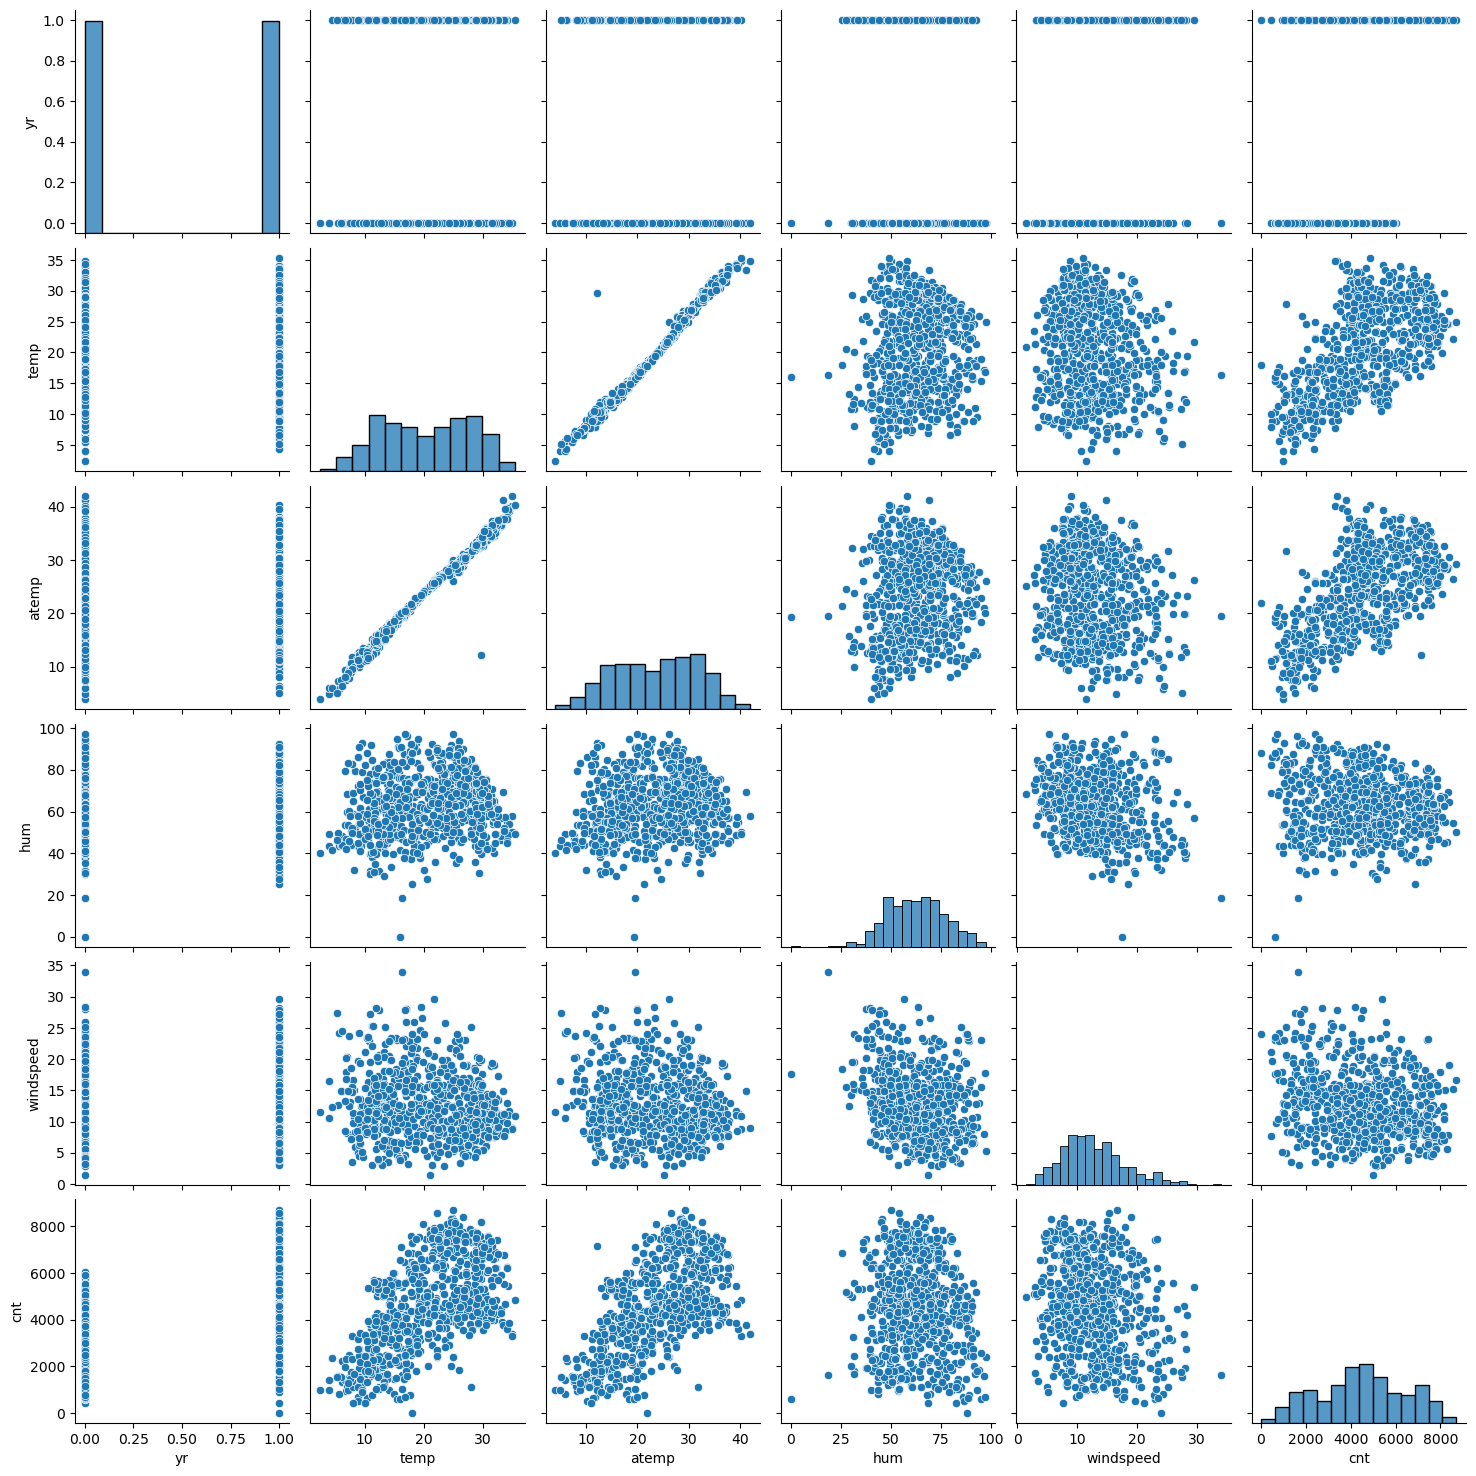

In [11]:
sns.pairplot(data=bike[num_columns])
plt.show()

#### Analyzing are prerdicator variable making any linear relationship with target variable cnt
    - cnt and temp seems to have linear relationship
    - cnt and atemp also have similar linear relationship as temp. this might be due to both temp and atemp are highly corrrelated. we can take out one of the variable.
    

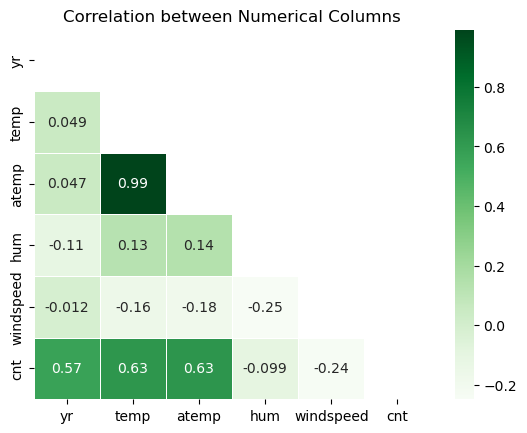

In [12]:
corr = bike[num_columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, linewidth=.5 , mask=mask , cmap="Greens")
plt.title("Correlation between Numerical Columns")
plt.show()

#### Summary
- tmp and cnt have high correlation. 
- windspeed have (-0.24) negative correlation with cnt. less windspeed better cnt
- There is high correlation between temp & atemp
- Because of multicolinearity ,we have to remove atemp column

In [13]:
# lets drop and update the numerical_column for future use
bike.drop('atemp',axis=1,inplace=True)   
num_columns = bike.select_dtypes('number').columns

In [14]:
# picking the columns of categorical type to analyzing against the target variable
cat_column = bike.select_dtypes('category').columns
print("Total catogorical column",len(cat_column))

Total catogorical column 6


In [78]:
# Function to plot boxplot for categorical variables 
def  plot_box(hue=None,label=None):
    plt.figure(figsize=(20, 20))
    plt_index=1
    for cat in cat_column:
        plt.subplot(3,2,plt_index)
        sns.boxplot(x=cat,y='cnt',data=bike,hue =hue)
        plt.xticks(rotation=45)
        if label is not None:
            plt.legend(labels=[2018,2019])
        plt_index+=1
    plt.show()

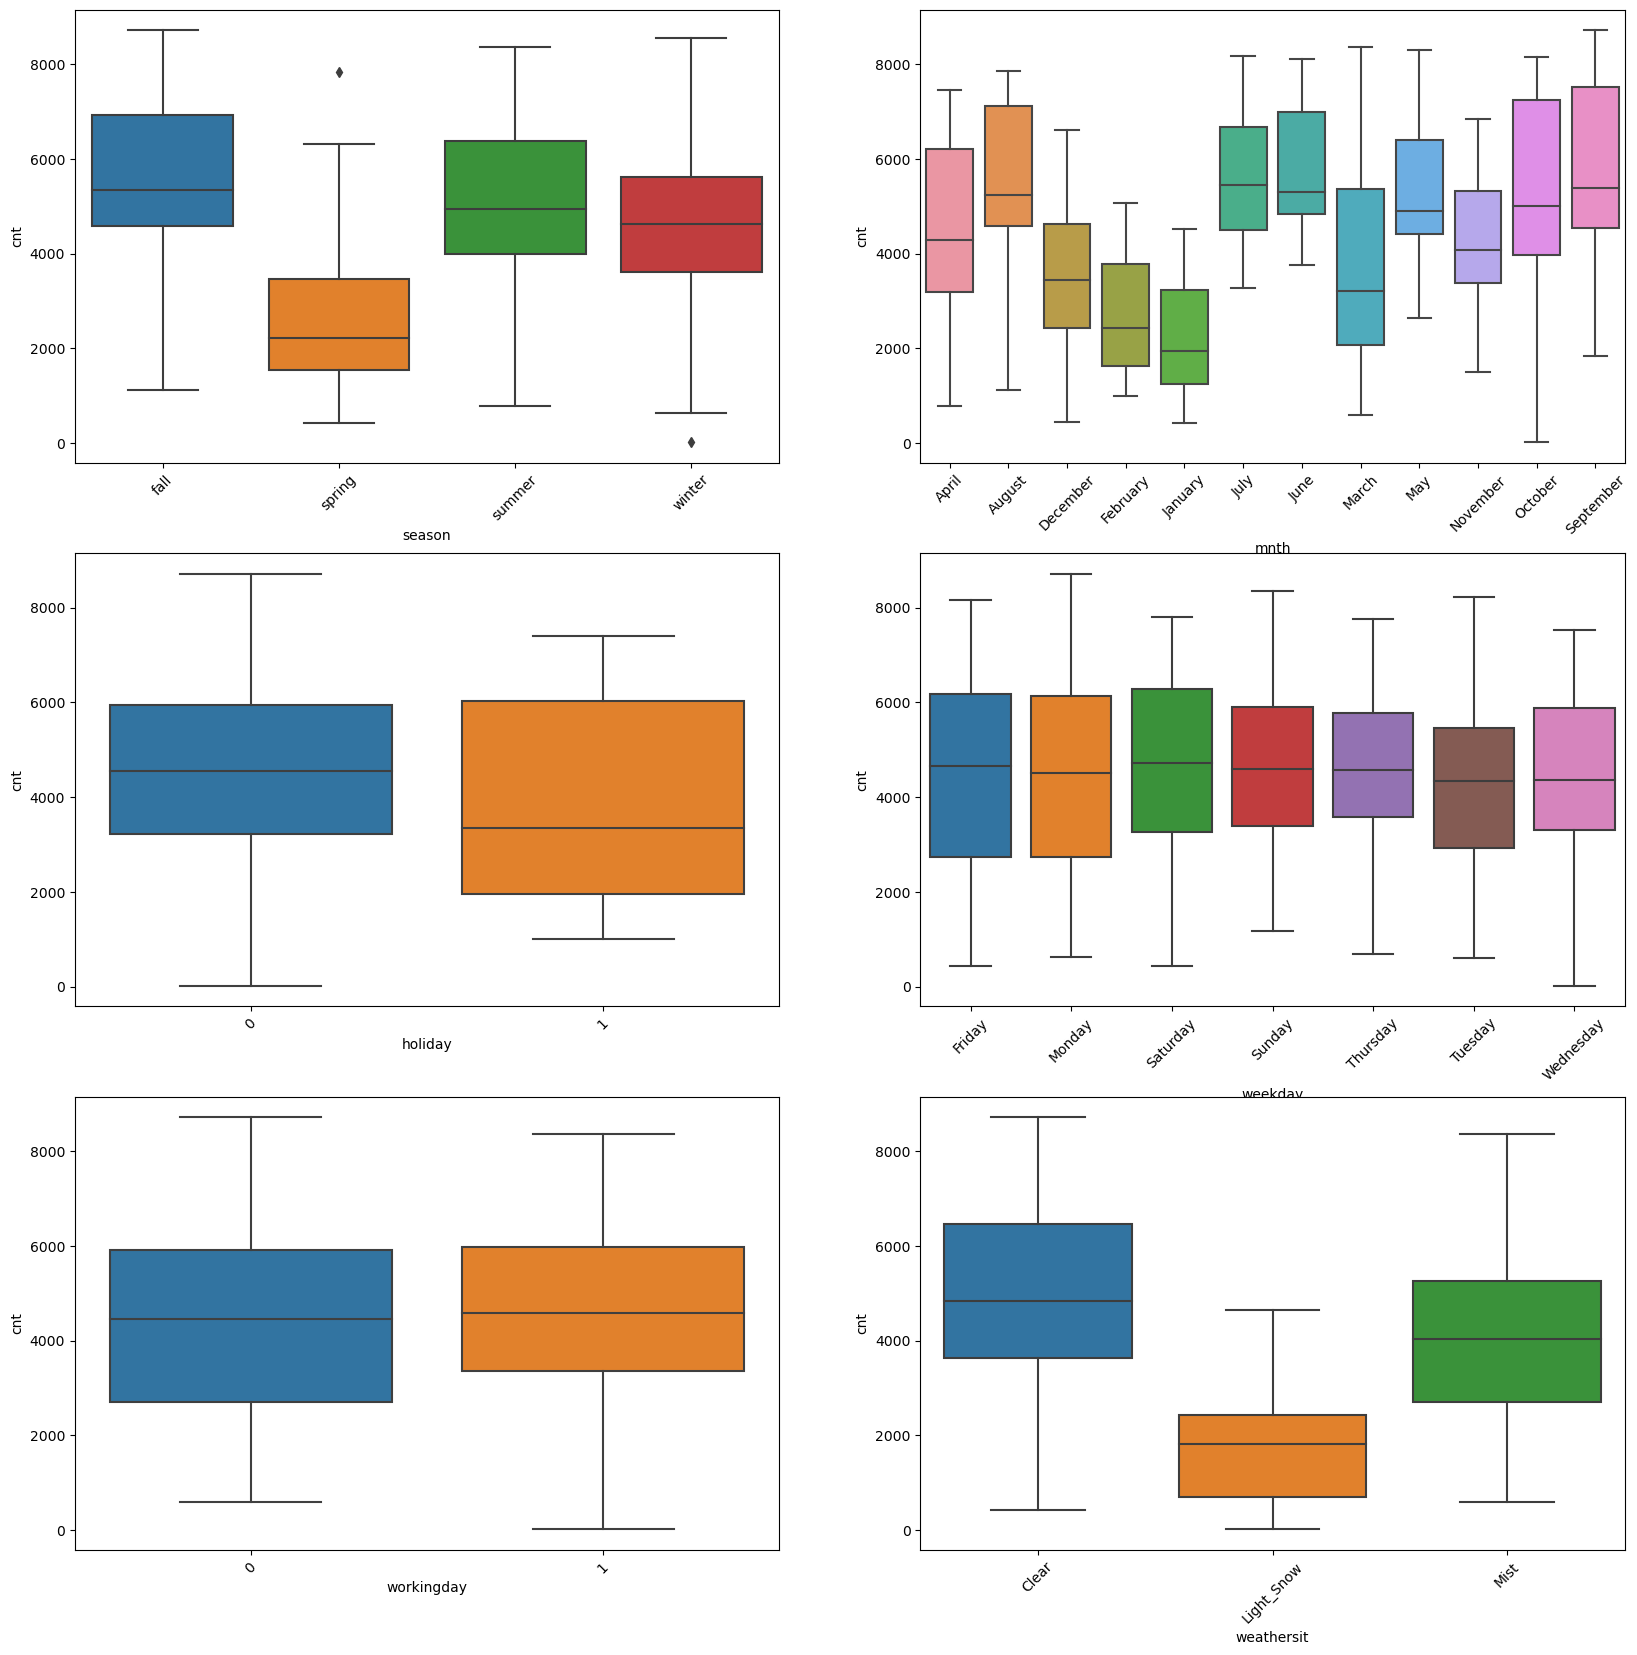

In [16]:
plot_box()


Analyzing categorical variables againsts the target variable
- Season Fall has the highest cnt across all season.
- August Septmeber October seem to have higer cnt. which correlate with Fall season. Seems people prefer Fall season to ride bike, that why there is a high demand.
- No major change in cnt on holidays. Doesnt impact the bike demand.
- No major change in cnt for weekday. Doesnt impact the bike demand
- No major change in cnt for working day. Doesnt impact the bike demand
- During Clear weather there is a hight cnt. people prefer clear weather to ride bike.

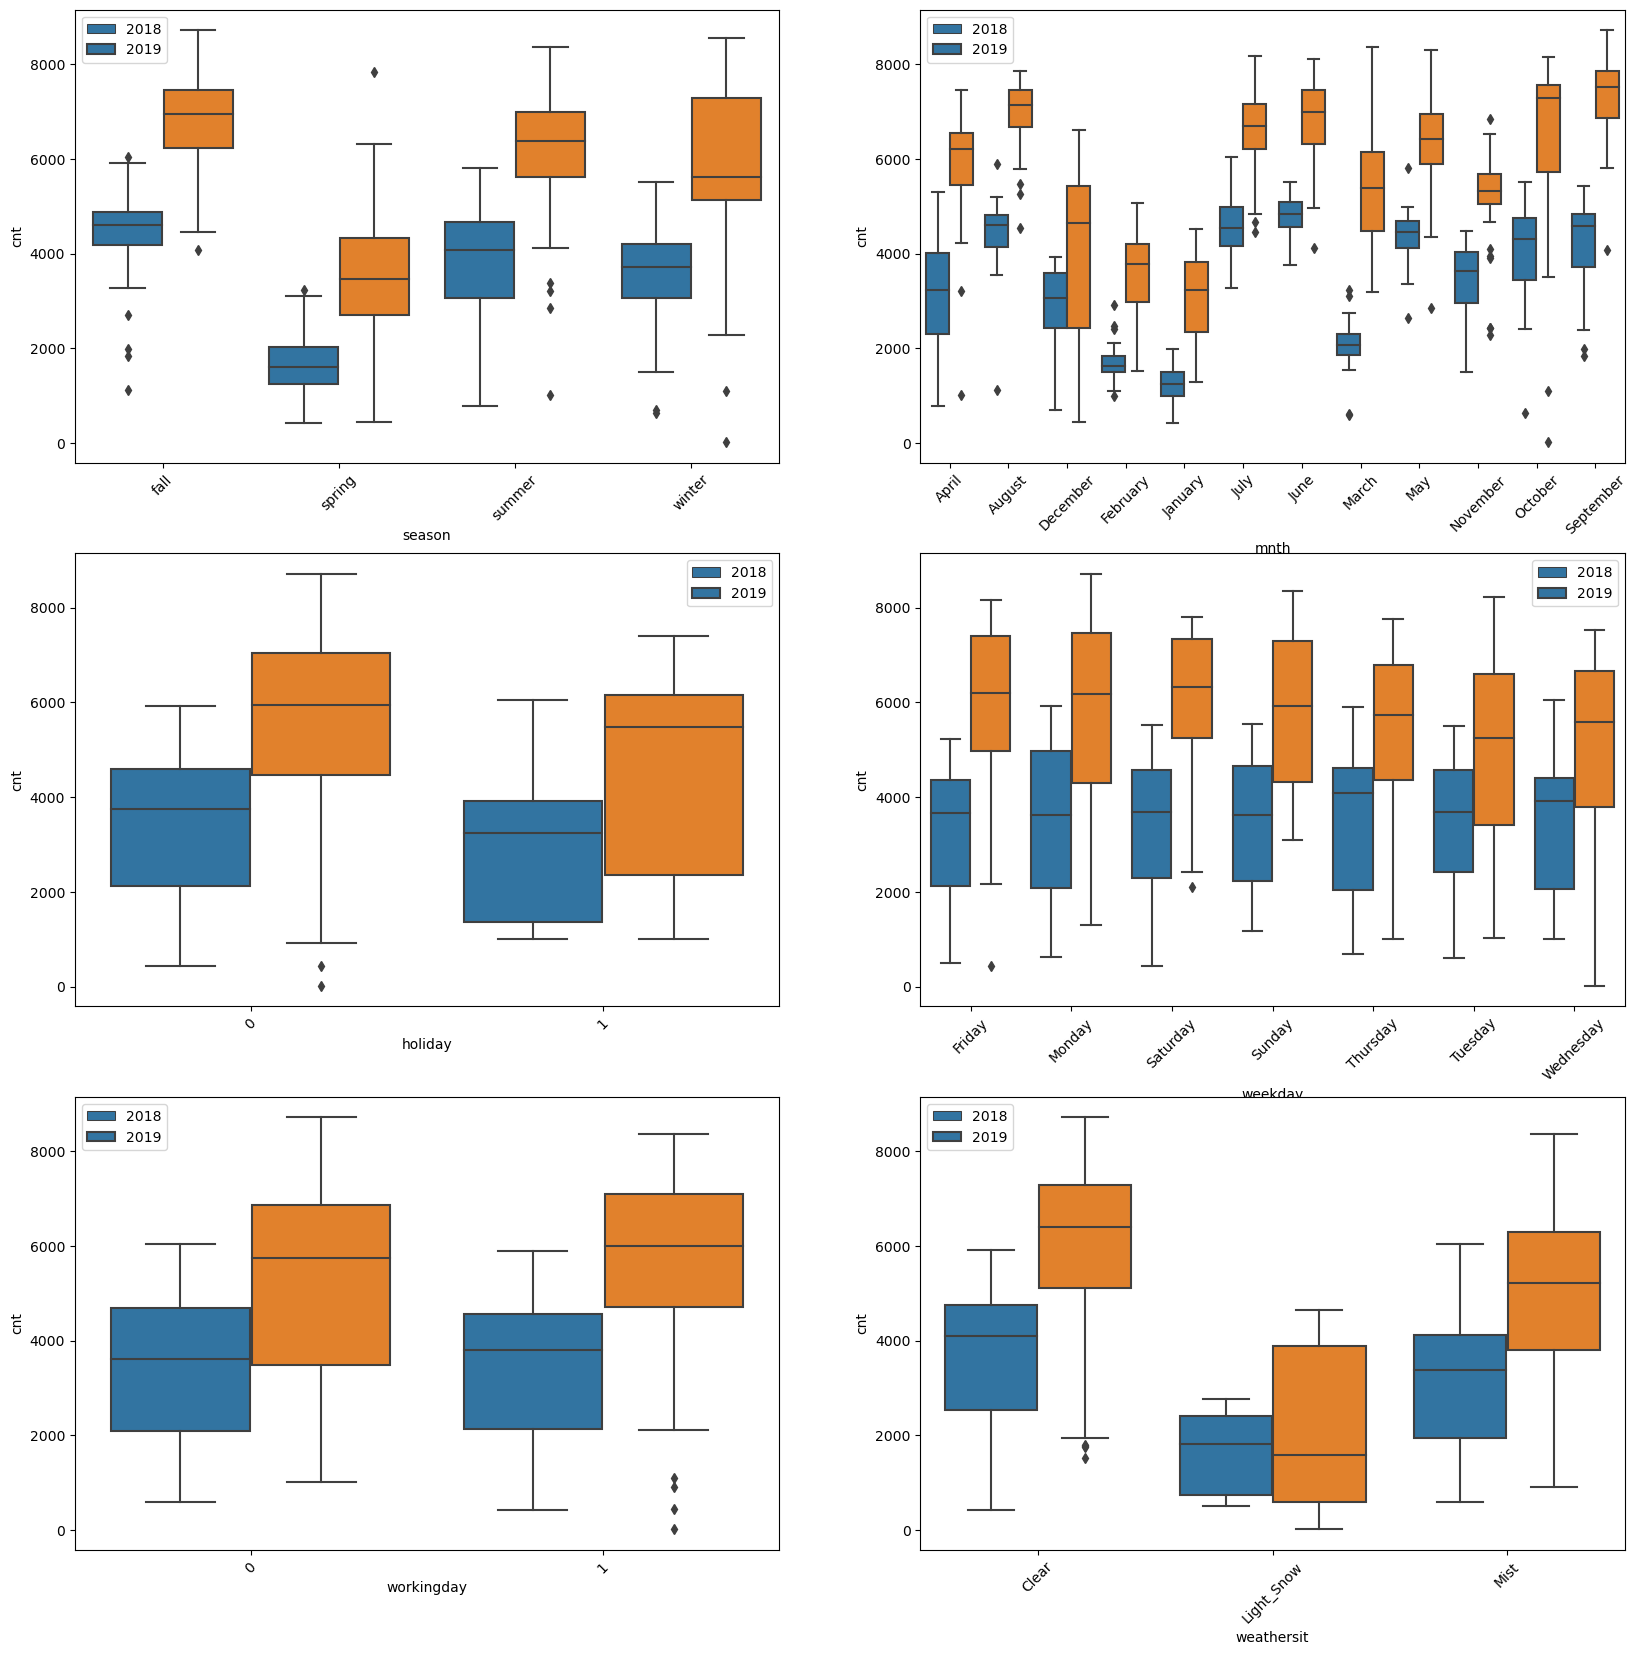

In [17]:
plot_box(hue='yr',label=[2018,2019])

#### Analyzing categorical variables againsts the target variable
    - In general there is a increase in the cnt year on year for all categories.
    - In season plot , fall has the highest cnt on year on year.
    - In Month plot, june has the higest cnt , august and july are close by in 2018. In 2019, september seems to be prefered month.
    - In holiday plot, mean is higher for cnt during holiday. 
    - In weekday, 2018 wednesday & sunday are preferred days . in 2019 friday & sunday seems to be preffered days.
    - WorkingDays are preferred 
    - In weathersit plot, Clear, Few clouds, Partly cloudy, Partly cloudy is prefferred weather. 


##  Data Preparation


##### One Hot Encoding on categorical variables

In [18]:
# Create Dummy Variables for categorical variable 
new_bike= pd.get_dummies(bike,columns=['season','mnth','weekday','weathersit'],drop_first=True)
new_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   yr                     730 non-null    int64   
 1   holiday                730 non-null    category
 2   workingday             730 non-null    category
 3   temp                   730 non-null    float64 
 4   hum                    730 non-null    float64 
 5   windspeed              730 non-null    float64 
 6   cnt                    730 non-null    int64   
 7   season_spring          730 non-null    uint8   
 8   season_summer          730 non-null    uint8   
 9   season_winter          730 non-null    uint8   
 10  mnth_August            730 non-null    uint8   
 11  mnth_December          730 non-null    uint8   
 12  mnth_February          730 non-null    uint8   
 13  mnth_January           730 non-null    uint8   
 14  mnth_July              730 non-null    uin

In [79]:
# converting to numerical variable to include in the computation of the regression model
new_bike['holiday'] = new_bike.holiday.astype('int64')
new_bike['workingday'] = new_bike.workingday.astype('int64')

In [20]:
new_bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     730 non-null    int64  
 1   holiday                730 non-null    int64  
 2   workingday             730 non-null    int64  
 3   temp                   730 non-null    float64
 4   hum                    730 non-null    float64
 5   windspeed              730 non-null    float64
 6   cnt                    730 non-null    int64  
 7   season_spring          730 non-null    uint8  
 8   season_summer          730 non-null    uint8  
 9   season_winter          730 non-null    uint8  
 10  mnth_August            730 non-null    uint8  
 11  mnth_December          730 non-null    uint8  
 12  mnth_February          730 non-null    uint8  
 13  mnth_January           730 non-null    uint8  
 14  mnth_July              730 non-null    uint8  
 15  mnth_J

##### 

In [21]:
# Verifying all the new_bike data 
print("Shape of the new_bike data after one hot encoding", new_bike.shape)
print("sample data of new_bike dataframe")
new_bike.head()

Shape of the new_bike data after one hot encoding (730, 29)
sample data of new_bike dataframe


,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Splitting the Data into Training and Testing Sets

In [80]:
# Split the new_bike dataset into train and test 70 /30 %

np.random.seed(0)
bike_train, bike_test = train_test_split(new_bike, train_size = 0.7, random_state = 100)


In [23]:
# verify the dataset bike_train and bike_test 
print(" Shape of the Bike_train ",bike_train.shape)
print(" Shape of the Bike_test ",bike_test.shape)

 Shape of the Bike_train  (510, 29)
 Shape of the Bike_test  (220, 29)


In [24]:
# lets pick numerical column , which doesnt have binary value (0/1) or one hot encoded
# we have num_columns Index from the previously done EDA.
lr_column = num_columns.tolist()
lr_column.remove('yr')
lr_column

['temp', 'hum', 'windspeed', 'cnt']

In [25]:
# Using MinMaxScaler to Rescale the featurres from the  Bike_train dataframe 

scaler = MinMaxScaler()
bike_train[lr_column] = scaler.fit_transform(bike_train[lr_column])


In [26]:
#verifying data after scaling
bike_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,1,0,0,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,1,0,0,...,0,0,1,0,0,0,0,0,0,1
728,1,0,0,0.245101,0.498067,0.663106,0.204096,1,0,0,...,0,0,0,0,0,0,1,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,...,0,0,1,0,0,0,0,0,0,1
111,0,0,1,0.345824,0.751824,0.380981,0.191095,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [27]:
bike_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,...,0.084314,0.080392,0.154902,0.133333,0.127451,0.131373,0.143137,0.150980,0.029412,0.345098
std,0.500429,0.157763,0.468282,0.225858,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,...,0.278131,0.272166,0.362166,0.340268,0.333805,0.338139,0.350557,0.358381,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### As we can see max is 1 and Min is 0 , MinMax scaling is done

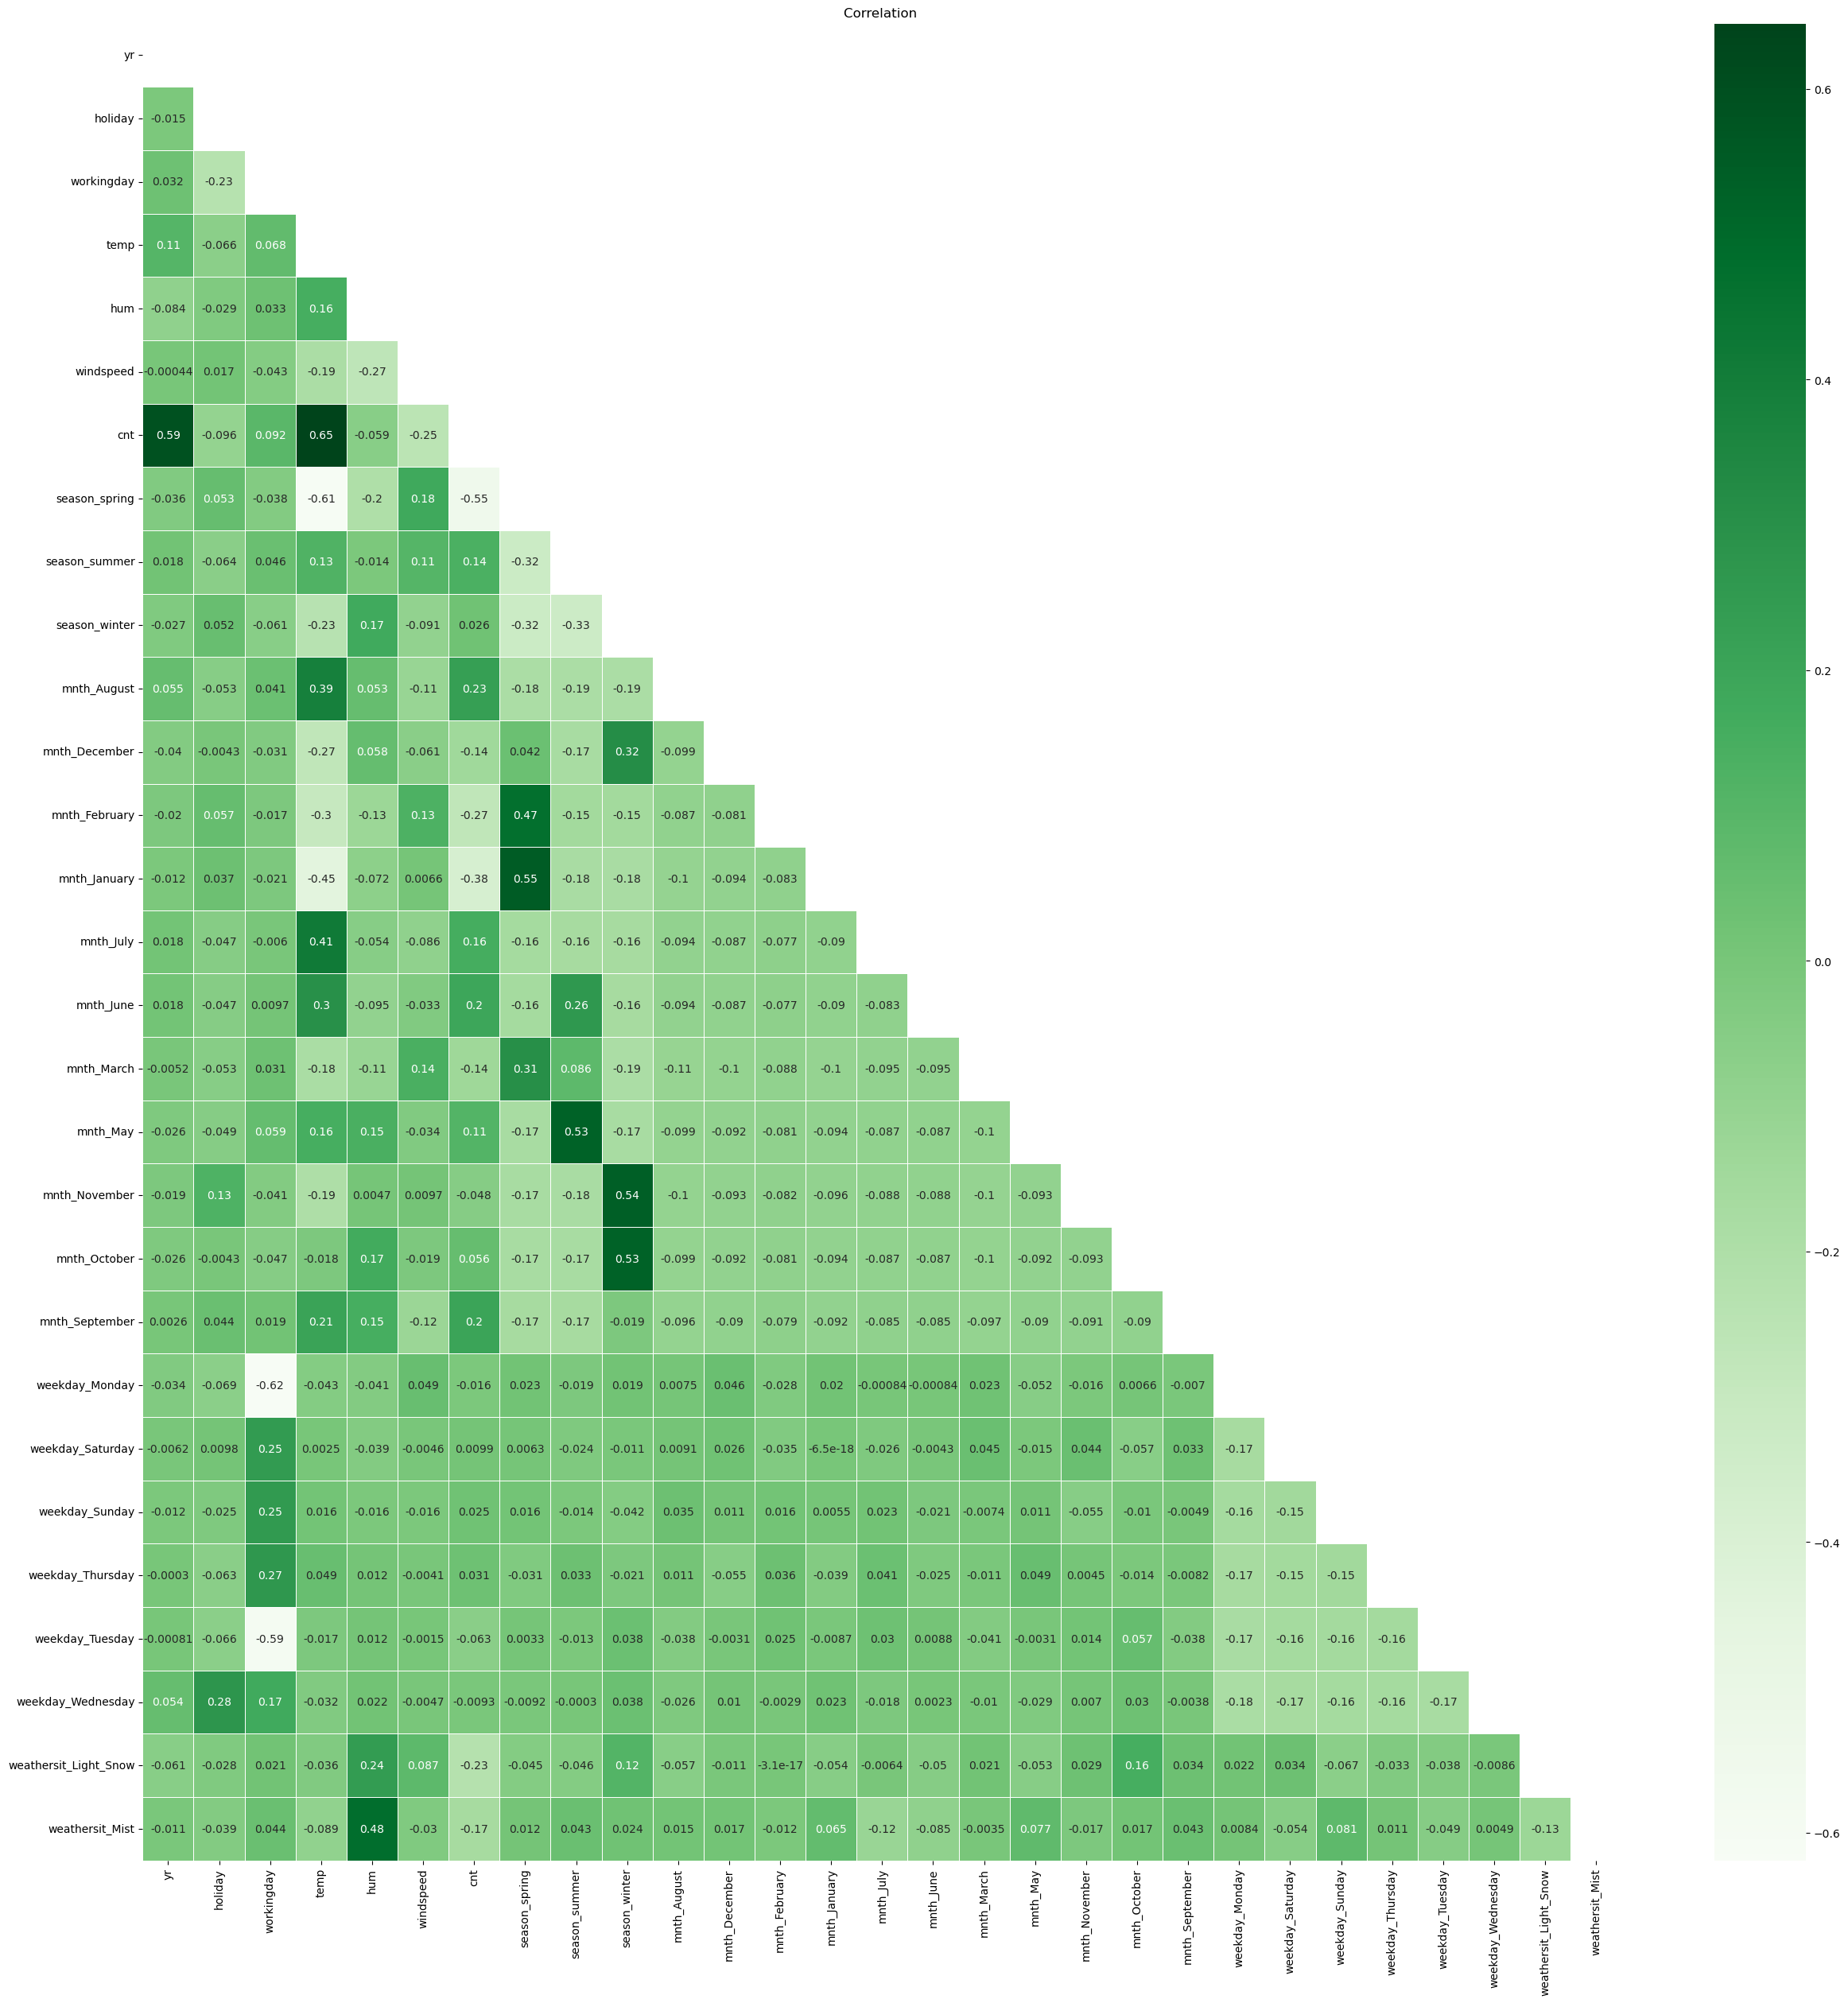

In [28]:
# Let's check the correlation coefficients to see which variables are highly correlated
train_corr = bike_train.corr()
plt.figure(figsize = (30, 30))
mask = np.zeros_like(train_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_corr, annot=True, linewidth=.5 , mask=mask , cmap="Greens")
plt.title("Correlation ")
plt.show()


#### Summary
- cnt have highest correlation with temp.
- cnt have negative correlation with season_spring, weather_light_snow, mnth_january ,mnth_feburary , windspeed
- cnt have postive correlation with mnth_septmenber, mnth_june ,mnth_august , yr and temp

In [29]:
# Dividing into X and y sets for the model building

y_train = bike_train.pop('cnt')
X_train = bike_train

In [30]:
X_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     510 non-null    int64  
 1   holiday                510 non-null    int64  
 2   workingday             510 non-null    int64  
 3   temp                   510 non-null    float64
 4   hum                    510 non-null    float64
 5   windspeed              510 non-null    float64
 6   season_spring          510 non-null    uint8  
 7   season_summer          510 non-null    uint8  
 8   season_winter          510 non-null    uint8  
 9   mnth_August            510 non-null    uint8  
 10  mnth_December          510 non-null    uint8  
 11  mnth_February          510 non-null    uint8  
 12  mnth_January           510 non-null    uint8  
 13  mnth_July              510 non-null    uint8  
 14  mnth_June              510 non-null    uint8  
 15  mnth

#### Building First model with all the features

In [31]:
X_train_const = sm.add_constant(X_train)
reg = sm.OLS(y_train,X_train_const).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     103.2
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          3.00e-181
Time:                        01:38:24   Log-Likelihood:                 527.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     482   BIC:                            -879.5
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.2409      0.036      6.786      0.000       0.171       0.311
yr                        0.2324      0.008     28.819      0.000       0.217       0.248
holiday                   0.0067      0.024      0.278      0.781      -0.041       0.054
workingday                0.0929      0.012      7.707      0.000       0.069       0.117
temp                      0.4454      0.046      9.628      0.000       0.354       0.536
hum                      -0.1515      0.039     -3.929      0.000      -0.227      -0.076
windspeed                -0.1860      0.026     -7.226      0.000      -0.237      -0.135
season_spring            -0.0448      0.030     -1.496      0.135      -0.104       0.014
season_summer             0.0430      0.026      1.645      0.101      -0.008       0.094
season_winter             0.1076      0.028      3.853      0.000       0.053       0.163
mnth_August               0.0204      0.034      0.607      0.544      -0.046       0.086
mnth_December            -0.0443      0.034     -1.317      0.189      -0.110       0.022
mnth_February            -0.0324      0.033     -0.985      0.325      -0.097       0.032
mnth_January             -0.0633      0.034     -1.885      0.060      -0.129       0.003
mnth_July                -0.0338      0.035     -0.969      0.333      -0.102       0.035
mnth_June                 0.0046      0.025      0.186      0.853      -0.044       0.053
mnth_March                0.0013      0.025      0.052      0.959      -0.047       0.050
mnth_May                  0.0247      0.021      1.173      0.241      -0.017       0.066
mnth_November            -0.0399      0.036     -1.096      0.274      -0.111       0.032
mnth_October              0.0075      0.036      0.210      0.834      -0.063       0.078
mnth_September            0.0859      0.032      2.692      0.007       0.023       0.149
weekday_Monday            0.0978      0.014      7.231      0.000       0.071       0.124
weekday_Saturday         -0.0036      0.015     -0.248      0.804      -0.032       0.025
weekday_Sunday            0.0055      0.015      0.368      0.713      -0.024       0.035
weekday_Thursday         -0.0124      0.015     -0.844      0.399      -0.041       0.017
weekday_Tuesday           0.0435      0.014      3.173      0.002       0.017       0.070
weekday_Wednesday        -0.0154      0.015     -1.057      0.291      -0.044       0.013
weathersit_Light_Snow    -0.2558      0.026     -9.699      0.000      -0.308      -0.204
weathersit_Mist          -0.0596      0.010     -5.709      0.000      -0.080      -0.039
==============================================================================
Omnibus:                       83.722   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarqu

#### Summary
- Adjusted R-Square is 0.844 which is excellent. 
- There are numnber of const with high p-value which need addressing like holiday ,mnth_June ,mnth_March ,mnth_October etc

 Instead of manually removing the features indivually .lets use RFE for feature selection 

In [32]:
# Recursive feature elimination for feature selection.
# lets pick the top 15 features then we will eliminate them one by one based on p-value and VIF
lr = LinearRegression()
lr.fit(X_train, y_train)

rfe = RFE(lr, n_features_to_select = 15)
rfe = rfe.fit(X_train, y_train)

In [33]:
# creating RFE DataFrame to easily access the output fo the RFE 
rfe_df = pd.DataFrame({'feature':X_train.columns, 'support':rfe.support_,'ranking':rfe.ranking_})
rfe_df.set_index('ranking',inplace=True)
rfe_df.sort_index(ascending=True)

,feature,support
ranking,,
1,yr,True
1,weekday_Monday,True
1,mnth_September,True
1,weathersit_Light_Snow,True
1,mnth_January,True
1,season_winter,True
1,season_summer,True
1,mnth_July,True
1,windspeed,True


In [34]:
#Selecting features frrom rfe output
rfe_columns = rfe_df[rfe_df.support].feature
rfe_columns

ranking
1                       yr
1                  holiday
1               workingday
1                     temp
1                      hum
1                windspeed
1            season_spring
1            season_summer
1            season_winter
1             mnth_January
1                mnth_July
1           mnth_September
1           weekday_Monday
1    weathersit_Light_Snow
1          weathersit_Mist
Name: feature, dtype: object

In [35]:
# lets check the rejected columns by RFE 
rfe_df[~rfe_df.support].feature

ranking
6           mnth_August
3         mnth_December
4         mnth_February
12            mnth_June
14           mnth_March
5              mnth_May
2         mnth_November
11         mnth_October
13     weekday_Saturday
10       weekday_Sunday
9      weekday_Thursday
7       weekday_Tuesday
8     weekday_Wednesday
Name: feature, dtype: object

**Insight**
- Doesnt seems any impotant feature that is eleiminated by RFE. we will continue with the RFE supported column

In [36]:
# Create the X_train using rfe column
X_train_rfe = X_train[rfe_columns]


#### Building First Model

In [37]:
# Building First Linear model

X_train_lr_1 = sm.add_constant(X_train_rfe)
lr_1 = sm.OLS(y_train,X_train_lr_1).fit()
print(lr_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          4.22e-191
Time:                        01:38:24   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.25

In [38]:
# Generic Method to Calulate VIF 
def calculateVIF(df):
    vif = pd.DataFrame({'feature': df.columns})
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [39]:
# Calculating the VIF for RFE Feature , and lets remove features with high VIF > 5 and compute model again
calculateVIF(X_train_rfe)

,feature,VIF
4,hum,29.37
3,temp,17.78
2,workingday,5.31
5,windspeed,4.73
6,season_spring,4.53
8,season_winter,3.46
7,season_summer,2.85
14,weathersit_Mist,2.29
0,yr,2.09
12,weekday_Monday,1.98


- hum , temp & workingday are showing high VIF
- we will remove feature indiviually to see the impact. removing one feature can change the VIF value, so we should alway remove one by one feature and see the impact. In our case lets start with hum column.

In [40]:
# removing hum column 
X_train_new = X_train_rfe.drop('hum',axis=1)

In [41]:
# Building Second Model
X_train_lr_2 = sm.add_constant(X_train_new)
lr_2 = sm.OLS(y_train,X_train_lr_2).fit()
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     189.6
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          1.60e-188
Time:                        01:38:24   Log-Likelihood:                 510.75
No. Observations:                 510   AIC:                            -991.5
Df Residuals:                     495   BIC:                            -928.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.17

**Insight**
- Holiday seems to have high p-value. Lets drop the variable

In [42]:
calculateVIF(X_train_new)

,feature,VIF
3,temp,7.07
2,workingday,5.24
4,windspeed,4.68
5,season_spring,3.07
6,season_summer,2.34
0,yr,2.08
7,season_winter,1.98
11,weekday_Monday,1.97
8,mnth_January,1.62
9,mnth_July,1.59


** Insight **
temp VIF seems higher tan 5. since we know from the fact temp have direct impact on the Bike Sharing.  We will reove oter features wit high p-value and VIF and check.


In [43]:
# Dropping holiday
X_train_new = X_train_new.drop('holiday',axis=1)

In [44]:
# Computing 3rd Model
X_train_lr_3 = sm.add_constant(X_train_new)
lr_3 = sm.OLS(y_train,X_train_lr_3).fit()
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.6
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          8.68e-189
Time:                        01:38:24   Log-Likelihood:                 508.61
No. Observations:                 510   AIC:                            -989.2
Df Residuals:                     496   BIC:                            -929.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.16

**Insight**
- removing the holiday have not effected our model accuracy r2 seems to 84%.
- mnth_January seems to high p-value.  Lets drop it

In [45]:
# checking for VIF
calculateVIF(X_train_new)

,feature,VIF
2,temp,6.82
1,workingday,4.68
3,windspeed,4.66
4,season_spring,2.99
5,season_summer,2.33
0,yr,2.08
6,season_winter,1.91
10,weekday_Monday,1.84
7,mnth_January,1.62
8,mnth_July,1.59


In [46]:
# Dropping the mnth_January variable 
X_train_new = X_train_new.drop('mnth_January',axis=1)

In [47]:
# Computing 4th Model  
X_train_lr_4 = sm.add_constant(X_train_new)
lr_4 = sm.OLS(y_train,X_train_lr_4).fit()
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.2
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          7.12e-189
Time:                        01:38:24   Log-Likelihood:                 506.01
No. Observations:                 510   AIC:                            -986.0
Df Residuals:                     497   BIC:                            -931.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.14

**Insight**
- Since removal of mnth_January feature didnt impact we can continue to reduce the feature to make the model much simpler.
- lets remove mnth_July and check the impact on the r2

In [48]:
calculateVIF(X_train_new)

,feature,VIF
2,temp,6.73
1,workingday,4.66
3,windspeed,4.64
4,season_spring,2.38
5,season_summer,2.32
0,yr,2.07
6,season_winter,1.91
9,weekday_Monday,1.83
7,mnth_July,1.58
11,weathersit_Mist,1.57


In [49]:
# Dropping mnth_July
X_train_new = X_train_new.drop('mnth_July',axis=1)


In [50]:
# Building 5th Model
X_train_lr_5 = sm.add_constant(X_train_new)
lr_5 = sm.OLS(y_train,X_train_lr_5).fit()
print(lr_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     233.6
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          1.42e-188
Time:                        01:38:24   Log-Likelihood:                 502.47
No. Observations:                 510   AIC:                            -980.9
Df Residuals:                     498   BIC:                            -930.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.14

**Insight**
- removal of mnth_July feature didnt impact our r2 score. Lets reduce to furthher reduce feature to make model simpler.
- Lets drop season_spring feature and check the impact.

In [51]:
calculateVIF(X_train_new)

,feature,VIF
2,temp,5.48
1,workingday,4.66
3,windspeed,4.64
4,season_spring,2.30
0,yr,2.07
5,season_summer,2.00
8,weekday_Monday,1.83
6,season_winter,1.76
10,weathersit_Mist,1.57
7,mnth_September,1.23


In [52]:
# Dropping season_spring
X_train_new = X_train_new.drop('season_spring',axis=1)


In [53]:
#Building 6thh Model
X_train_lr_6 = sm.add_constant(X_train_new)
lr_6 = sm.OLS(y_train,X_train_lr_6).fit()
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          3.13e-188
Time:                        01:38:24   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.07

**Insight**
- Since removing season_spring fearture didnt affect the model score ( r2 -score ). we can reduce the some more featurre to make the model simpler.


In [54]:
calculateVIF(X_train_new)

,feature,VIF
2,temp,4.76
1,workingday,4.04
3,windspeed,3.44
0,yr,2.02
7,weekday_Monday,1.69
4,season_summer,1.57
9,weathersit_Mist,1.53
5,season_winter,1.40
6,mnth_September,1.20
8,weathersit_Light_Snow,1.08


**Insight**
VIF of temp is <5 which is okay. As temp being one of th important factor lets take second highest VIF value working day. Since we know from that from earlier working day doesnt ahve significant impact on the cnt variable . lets drop workingday

In [55]:
X_train_new = X_train_new.drop('workingday',axis=1)


In [56]:
X_train_lr_7 = sm.add_constant(X_train_new)
lr_7 = sm.OLS(y_train,X_train_lr_7).fit()
print(lr_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     265.5
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          3.99e-184
Time:                        01:38:25   Log-Likelihood:                 486.20
No. Observations:                 510   AIC:                            -952.4
Df Residuals:                     500   BIC:                            -910.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.11

**Insight**
- After removing workingday there isnt significant drop in r2 score. 
- weekday_Monday seems to hhave high p-value. lets drop it.

In [57]:
calculateVIF(X_train_new)

,feature,VIF
1,temp,3.70
2,windspeed,3.09
0,yr,2.00
3,season_summer,1.57
8,weathersit_Mist,1.48
4,season_winter,1.37
5,mnth_September,1.20
6,weekday_Monday,1.18
7,weathersit_Light_Snow,1.08


**Insight**
- temp VIf have come down significantly. lets drop the variable with high p-value weekday_Monday. 

In [58]:
X_train_new = X_train_new.drop('weekday_Monday',axis=1)

In [59]:
#Bulding 8th model
X_train_lr_8 = sm.add_constant(X_train_new)
lr_8 = sm.OLS(y_train,X_train_lr_8).fit()
print(lr_8.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     296.5
Date:                Wed, 15 Mar 2023   Prob (F-statistic):          1.53e-184
Time:                        01:38:25   Log-Likelihood:                 484.24
No. Observations:                 510   AIC:                            -950.5
Df Residuals:                     501   BIC:                            -912.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.12

**Insight**
- r2 score hasnt dropped after remove weekday_Monday fetaure.
- there is no feature with high p-value. 

In [60]:
calculateVIF(X_train_new)

,feature,VIF
1,temp,3.68
2,windspeed,3.03
0,yr,2.00
3,season_summer,1.57
7,weathersit_Mist,1.48
4,season_winter,1.37
5,mnth_September,1.20
6,weathersit_Light_Snow,1.08


We can consider the above model i.e lr_8, as it seems to have very low multicolinearity between the predictors and the p-values for all the predictors seems to be significant.
F-Statistics value of 296.5 (which is greater than 1) and the Prob (F-statistic) of 1.53e-184 i.e almost equals to zero, states that the overall model is significant

In [61]:
# Checking the parameters and their coefficient values
lr_8.params

const                    0.120918
yr                       0.233163
temp                     0.552655
windspeed               -0.155224
season_summer            0.089399
season_winter            0.128144
mnth_September           0.097843
weathersit_Light_Snow   -0.278528
weathersit_Mist         -0.076670
dtype: float64

### Residual Analysis of the train data and validation

##### To validated model we need to check few assumption of linear regression model. 

In [63]:
y_train_pred = lr_8.predict(X_train_lr_8)
residual = (y_train - y_train_pred)

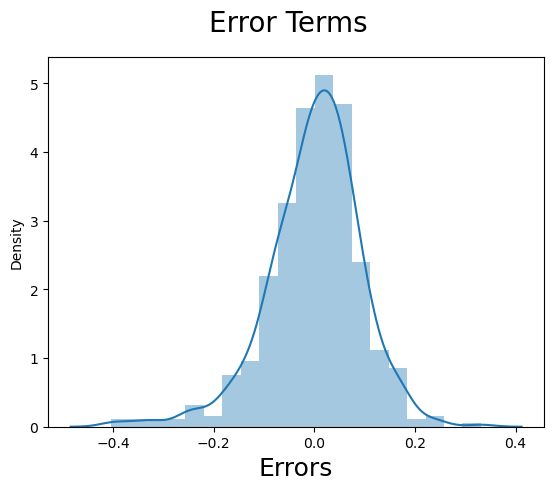

In [64]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20) 
plt.xlabel('Errors', fontsize = 18)
plt.show()

- Our assumption that residual error plot should be normally distributed andmean should be 0 or close to 0 as much as possible stands valid.

In [65]:
# VIF for multicollinearity
calculateVIF(X_train_new)

,feature,VIF
1,temp,3.68
2,windspeed,3.03
0,yr,2.00
3,season_summer,1.57
7,weathersit_Mist,1.48
4,season_winter,1.37
5,mnth_September,1.20
6,weathersit_Light_Snow,1.08


**Insight**
- There is no multicollinearity as the VIF value is VIF < 5. Generally  VIF >1 & VIF <5 moderate correlation, VIF < 5 critical level of multicollinearity.

#### Linearity between independent & dependent variable

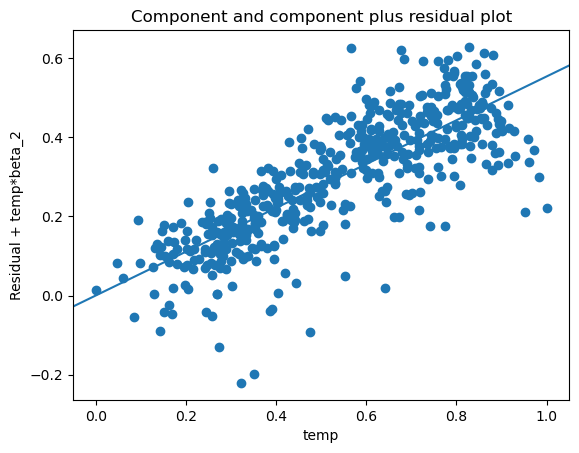

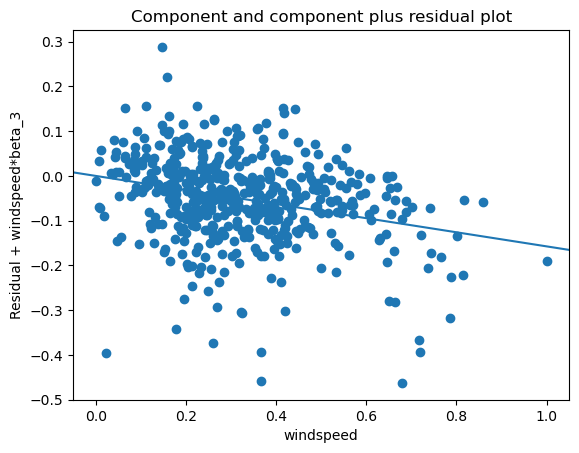

In [66]:
# we will use ccpr plot to chheck the linearity between thhe independent and dependent variable.
# The CCPR plot provides a way to judge the effect of one regressor on the response variable by taking into account the effects of the other independent variables. 
sm.graphics.plot_ccpr(lr_7, 'temp')
plt.show()
sm.graphics.plot_ccpr(lr_7, 'windspeed')
plt.show()


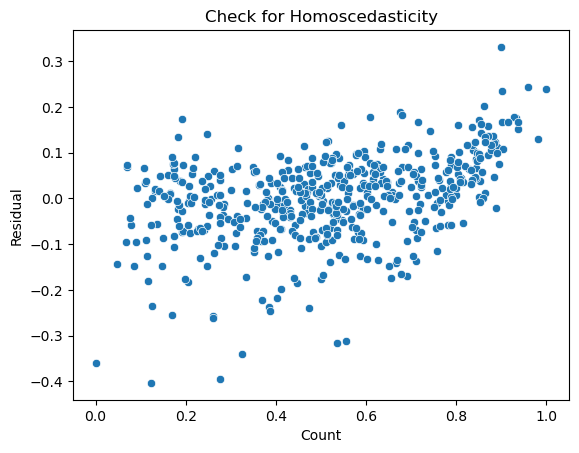

In [67]:
# Check for Homoscedasticity
sns.scatterplot(y_train,residual)
plt.xlabel('Count')
plt.ylabel('Residual')
plt.title('Check for Homoscedasticity')
plt.show()

- There is no visible pattern seen on the plot.

### Making Predictions 

In [68]:
print(lr_column)
bike_test[lr_column] = scaler.transform(bike_test[lr_column])
bike_test.head()

['temp', 'hum', 'windspeed', 'cnt']


,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
184,0,1,0,0.831783,0.657364,0.084219,0.692706,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,0.901354,0.610133,0.153728,0.712034,0,1,0,...,0,0,0,0,0,0,0,0,0,0
299,0,0,1,0.511964,0.837699,0.334206,0.303382,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,0.881625,0.437098,0.339570,0.547400,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,1,0.817246,0.314298,0.537414,0.569029,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [69]:
bike_test.describe()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Light_Snow,weathersit_Mist
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,...,0.086364,0.086364,0.118182,0.163636,0.177273,0.168182,0.145455,0.127273,0.027273,0.318182
std,0.500809,0.187620,0.459303,0.233187,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,...,0.281541,0.281541,0.323559,0.370789,0.382770,0.374881,0.353363,0.334038,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
# creating y_test and X_test
y_test = bike_test.pop('cnt')
X_test = bike_test

In [71]:
# picking the same column as in the final present in teh final model
X_test = bike_test[X_train_new.columns]

In [72]:
# predicting using the final model 
X_test_lr = sm.add_constant(X_test)
y_test_pred = lr_8.predict(X_test_lr)

In [73]:
# calculating r2 score
r2 = r2_score(y_test, y_test_pred)
round(r2,4)

0.7908

### Model Evaluation

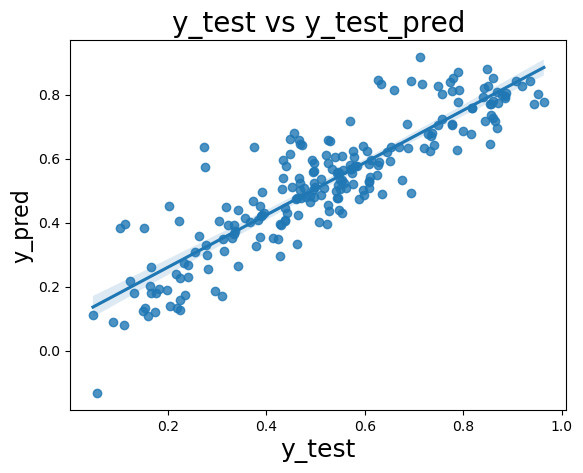

In [74]:
# lets plot ytest vs ypred
sns.regplot(y_test, y_test_pred)
plt.title('y_test vs y_test_pred', fontsize = 20) 
plt.xlabel('y_test', fontsize = 18)
plt.ylabel('y_pred', fontsize = 16) 
plt.show()

- Above plot there isnt much spread, so our model is doing pretty good.

In [75]:
round(lr_8.params,4)

const                    0.1209
yr                       0.2332
temp                     0.5527
windspeed               -0.1552
season_summer            0.0894
season_winter            0.1281
mnth_September           0.0978
weathersit_Light_Snow   -0.2785
weathersit_Mist         -0.0767
dtype: float64

We can see that the equation of our best fitted line is:

- `cnt =  0.1209 +  0.2332*yr + 0.5527*temp - 0.1552*windspeed + 0.0894*season_summer + 0.1281*season_winter + 0.0978*mnth_September - 0.2785*weathersit_Light_Snow - 0.0767*weathersit_Mist `


In [76]:
test_adjusted_r2 = round(1-((1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)),4)
print("Test Dataset Adjusted R square",test_adjusted_r2)

Test Dataset Adjusted R square 0.7828


### Comparision between Training and Testing dataset:
- **Train dataset R^2          :  0.826**
- **Test dataset R^2           : 0.7908**
- **Train dataset Adjusted R^2 : 0.823**  
- **Test dataset Adjusted R^2  : 0.7828**

 Demand of bikes depend on  *temp, windspeed, yr, season_summer, season_winter, mnth_September, weathersit_Light_Snow , weathersit_Mist*


#### As per our final Model,  predictor variables that influences the bike booking are:

- **Temperature (temp):** A coefficient value of ‘0.5527’ indicated that a unit increase in temp variable increases the bike demand ( cnt ) by 0.5527 units.

- **Year (yr) :** A coefficient value of ‘0.2332’ indicated that a unit increase in yr variable increases the bike demand (cnt) by 0.2332 units.

- **windspeed :** A coefficient value of ‘-0.1552’ indicated that a unit increase in windspeed variable decrease the bike demand (cnt) by -0.1552 units. As windspeed is negatively correlated. bike hire prefer less windy days.

- **season_summer :** A coefficient value of ‘0.0894’ indicated that a unit increase in season_summer ( summer season) variable increases the bike demand (cnt) by 0.0894 units.

- **season_winter :** A coefficient value of ‘0.1281’ indicated that a unit increase in season_winter ( winter season) variable increases the bike demand (cnt) by 0.1281 units.

- **mnth_September :** A coefficient value of ‘0.0894’ indicated that a unit increase in mnth_September ( September Month) variable increases the bike demand (cnt) by 0.0894 units.

- **weathersit_Light_Snow :** A coefficient value of ‘-0.2785’ indicated that a unit increase in weathersit_Light_Snow ( Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds ) variable decreases the bike demand (cnt) by -0.2785 units. People doesnt prefer snowy , rain etc days as it harder to drive the bike.

- **weathersit_Mist :** A coefficient value of ‘-0.0767’ indicated that a unit increase in weathersit_Mist ( Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist) variable decreases the bike demand (cnt) by -0.0767 units. People doesnt prefer Misty , mist +cloudy etc days as it harder to drive the bike because of poor visibility.
